# Banknote Authentication with k-NN and Logistic Regression

In this assignment, we build classification models to detect **fake banknotes** using the  
[UCI Banknote Authentication Dataset](https://archive.ics.uci.edu/ml/datasets/banknote+authentication).

Our goals are to:

- Implement **k-nearest neighbors (k-NN)** and **logistic regression** classifiers  
- Evaluate how well each model distinguishes **real** vs **fake** banknotes  
- Compare the **importance and impact of features** on classification accuracy


In [140]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

## Dataset Description

The dataset contains **1,372 banknotes**, each described by four continuous features extracted from 400×400 gray-scale images using a **wavelet transform**:

1. `f1` – variance of the wavelet-transformed image  
2. `f2` – skewness of the wavelet-transformed image  
3. `f3` – curtosis of the wavelet-transformed image  
4. `f4` – entropy of the image  

The target variable is:

- `class` – banknote label  
  - `0` → **genuine** (legitimate) banknote – shown as **green / “+”**  
  - `1` → **fake** (counterfeit) banknote – shown as **red / “−”**

Conceptually, we assume:

- **Step 1:** A relatively cheap machine extracts the four features for each banknote.  
- **Step 2:** A more expensive process (advanced machine or human experts) assigns the true class label.

Our goal is to train a classifier that can **replace Step 2** and make accurate predictions using only the four features from Step 1.


In [ ]:
data = pd.read_csv('data_banknote_authentication.csv')
data['color'] = np.where(data['class'] == 0, 'green', 'red')

print(data.head())

features = data.columns[:4]
mean={}
std={}
for label in data['color'].unique():
    mean[label] = np.mean(data[data['color'] == label][features], axis=0)
    std[label] = np.std(data[data['color'] == label][features], axis=0)

mean['all'] = np.mean(data[features], axis=0)
std['all'] = np.std(data[features], axis=0)


table = pd.DataFrame({
    'class': ['0', '1', 'all'],
    **{f'μ(f{i+1})': [mean['green'][f], mean['red'][f], mean['all'][f]] for i, f in enumerate(features)},
    **{f'σ(f{i+1})': [std['green'][f], std['red'][f], std['all'][f]] for i, f in enumerate(features)}
})
table = table.round(3)
table

   variance  skewness  curtosis  entropy  class  color
0   3.62160    8.6661   -2.8073 -0.44699      0  green
1   4.54590    8.1674   -2.4586 -1.46210      0  green
2   3.86600   -2.6383    1.9242  0.10645      0  green
3   3.45660    9.5228   -4.0112 -3.59440      0  green
4   0.32924   -4.4552    4.5718 -0.98880      0  green


,class,μ(f1),μ(f2),μ(f3),μ(f4),σ(f1),σ(f2),σ(f3),σ(f4)
0,0,2.277,4.257,0.797,-1.148,2.018,5.135,3.238,2.124
1,1,-1.868,-0.994,2.148,-1.247,1.880,5.400,5.257,2.069
2,all,0.434,1.922,1.398,-1.192,2.842,5.867,4.308,2.100


From the table, we see that real banknotes (class 0) have positive mean values for the first three features (variance, skewness, curtosis) and a negative mean for entropy. In contrast, fake banknotes (class 1) have lower or negative means for f1 and f2, and a higher mean for f3.

The gap in curtosis (f3) is especially notable, which is about two standard deviations, indicating it could serve as a strong discriminative feature. 

Furthermore, the standard deviations are relatively similar across both classes, implying that while the two groups differ in their central tendencies (means), their within-class variability is comparable. This pattern supports the idea that variance, skewness, and curtosis together provide a reliable basis for classifying banknotes.

## Train–Test Split and Preprocessing

To evaluate model performance, we:

- Split the data into **training** and **test** sets  
- Optionally scale features using **standardization**, which is especially important for distance-based models like k-NN

The test set will be used **only** for final evaluation, to estimate how well our models generalize to unseen banknotes.


<Figure size 600x600 with 0 Axes>

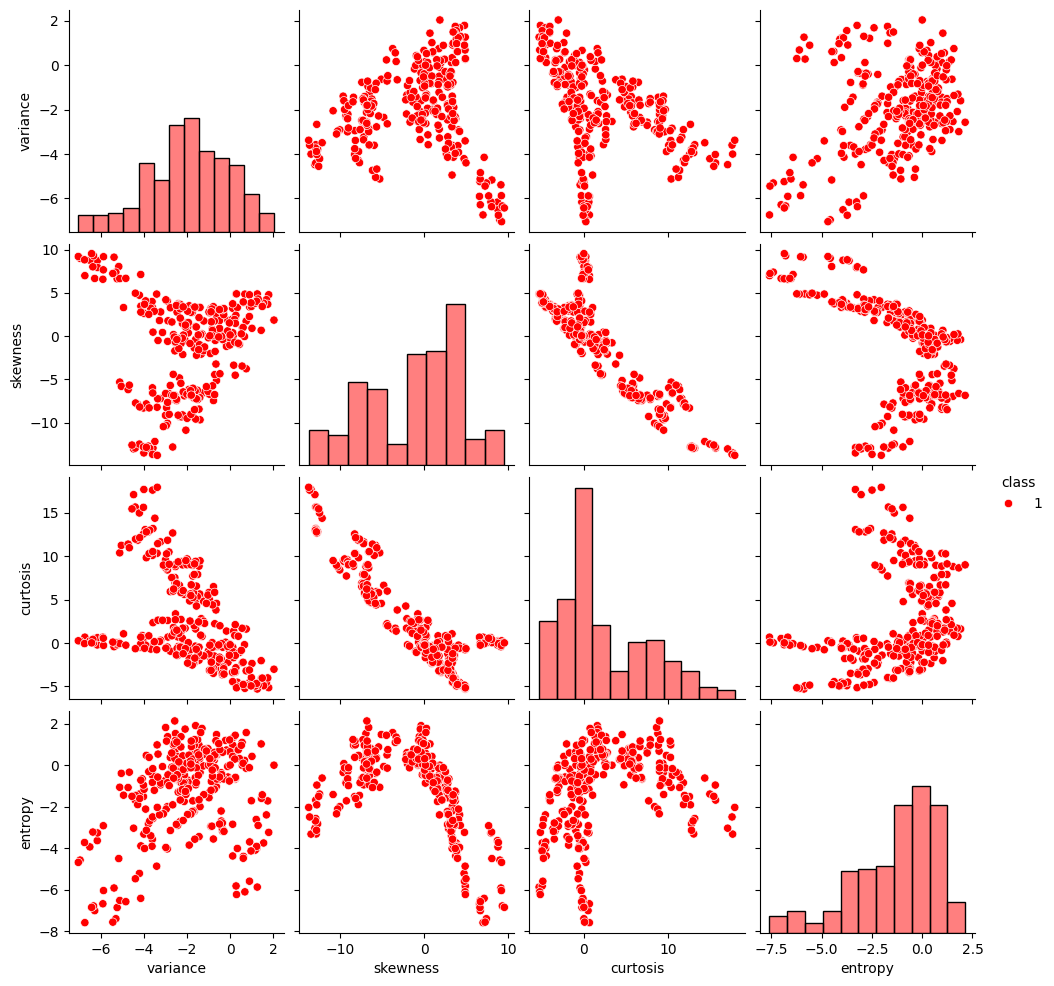

<Figure size 600x600 with 0 Axes>

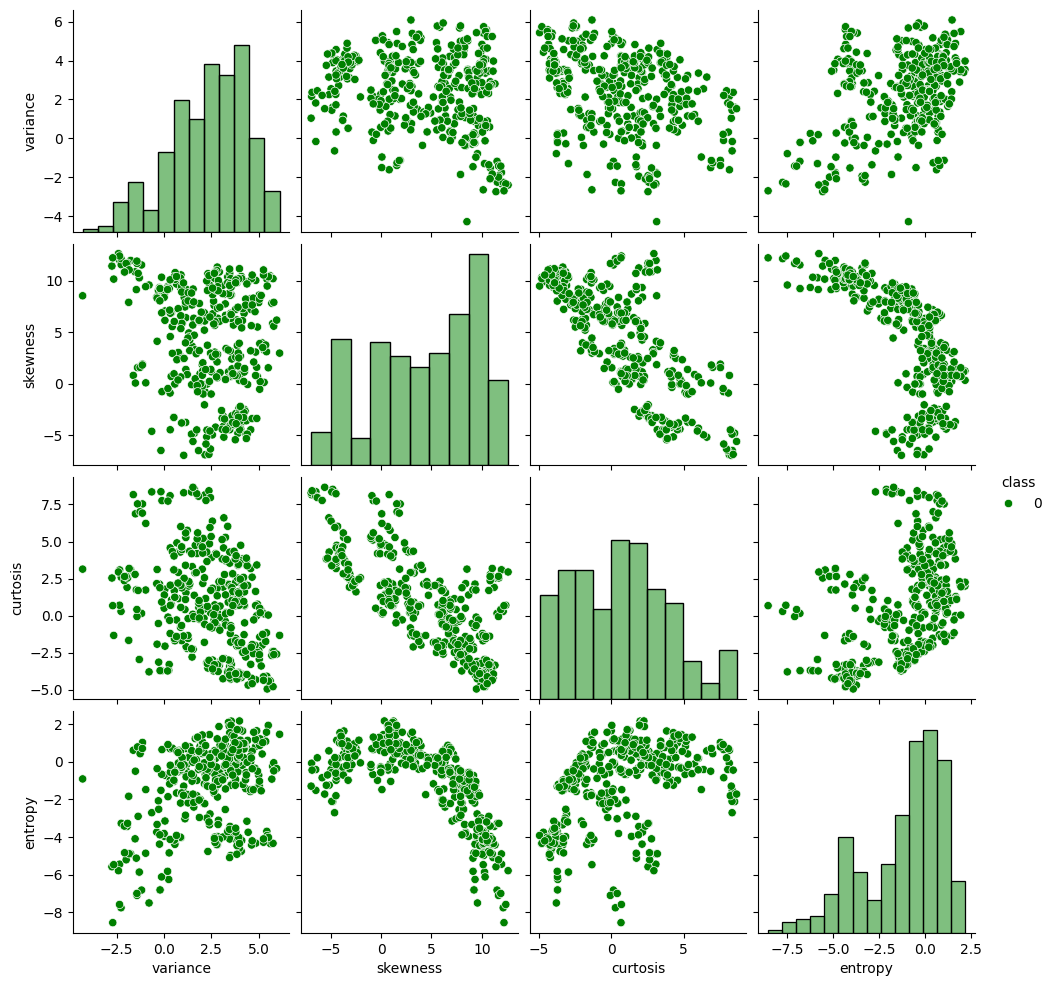

In [ ]:
X = data[features]
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=79)

df_train = pd.DataFrame(X_train, columns=features)
df_train['class'] = y_train


plt.figure(figsize=(6, 6))
sns.pairplot(df_train[df_train['class'] == 1], diag_kind='hist', hue='class', palette=['red'])
plt.savefig(f'bad_bills.pdf', dpi=150)
plt.show()

plt.figure(figsize=(6, 6))
sns.pairplot(df_train[df_train['class'] == 0], diag_kind='hist', hue='class', palette=['green'])
plt.savefig(f'good_bills.pdf', dpi=150)
plt.show()


In [143]:
def simple_classifier(df):
    return np.where((df['variance']<0) & (df['curtosis']<0), 1, 0)

X_train['predicted'] = simple_classifier(X_train)
X_test['predicted'] = simple_classifier(X_test)
print("Train accuracy:", accuracy_score(y_train, X_train['predicted']))
print("Test accuracy:", accuracy_score(y_test, X_test['predicted']))

Train accuracy: 0.685131195335277
Test accuracy: 0.6501457725947521


By looking at the distribution of each feature, we can see that f1 (variance) and f3 (curtosis) show the most distinct separation between the two classes.

Based on this, I set a simple rule-based classifier: if variance < 0 and curtosis < 0, classify as fake (1), else real (0). 

This classifier achieves 65% accuracy on the test set, which is quite good for such a simple approach using straighforward rule.

In [144]:
acc = accuracy_score(y_test, X_test['predicted'])
cm = confusion_matrix(y_test, X_test['predicted'])

tn, fp, fn, tp = cm.ravel()
tpr = tp/(tp+fn)
fpr = fp/(fp+tn)

table = pd.DataFrame({
    'TP': [tp],
    'FP': [fp],
    'TN': [tn],
    'FN': [fn],
    'accuracy': [acc],
    'TPR': [tpr],
    'FPR': [fpr]
})
table = table.round(3)
table

,TP,FP,TN,FN,accuracy,TPR,FPR
0,89,12,357,228,0.65,0.281,0.033


We observe that out of all true labels, the classifier correctly identified 89 fake banknotes, while 357 real ones were correctly recognized. However, 228 fake banknotes were misclassified as real, leading to low value of TPR (0.281).

The False Positive Rate (FPR = 0.03), on the other hand, remains low, meaning real banknotes are rarely labeled as fake.

## k-NN Classifier

We begin by implementing the **k-nearest neighbors (k-NN)** classifier to distinguish between
real and fake banknotes using the four wavelet-transform features.

Since k-NN performance depends heavily on the choice of **k**, we perform the following steps:

1. Split the dataset into training and test sets (50/50 split, stratified).  
2. Further split the training set into an **inner train/validation** split to tune k.  
3. Standardize features using `StandardScaler`, because k-NN relies on Euclidean distance.  
4. Evaluate accuracy across several values of k:  
   $$k \in \{3, 5, 7, 9, 11\}$$
5. Select the k that yields the highest validation accuracy.


### Selecting the Optimal Value of k

The plot below shows validation accuracy for different values of k.  
We choose the value that maximizes validation accuracy, balancing performance and model simplicity.


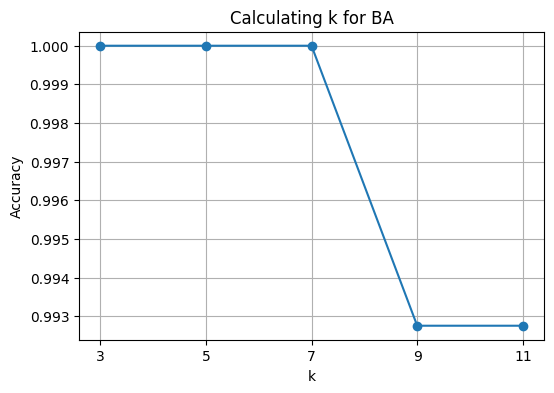

In [ ]:
features = data.columns[:4]
X = data[features].to_numpy()
y = data['class'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=79, stratify= y)


# split train set into train and test, to find best k value for k-nn classifier
X_train_inner, X_val, y_train_inner, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=79, stratify=y_train)

scaler = StandardScaler()
X_train_inner = scaler.fit_transform(X_train_inner)
X_val = scaler.transform(X_val)

accs = []
k_values = [3,5,7,9,11]
for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train_inner, y_train_inner)
    acc = knn_classifier.score(X_val, y_val)
    accs.append(acc)


plt.figure(figsize=(6,4))
plt.plot(k_values, accs, marker='o')
plt.xticks(k_values)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Calculating k for BA')
plt.grid(True)
plt.show()


From the validation results, **k = 3** achieves the highest accuracy (1.0), making it the optimal
choice for this dataset.

### Evaluating k-NN with the Optimal k

Using **k = 3**, we retrain the model on the full training set (after scaling) and evaluate it on
the test set. We compute:

- Train and test accuracy  
- Confusion matrix (TP, FP, TN, FN)  
- True Positive Rate (TPR)  
- False Positive Rate (FPR)  

These metrics help us understand both overall performance and how well the model detects counterfeit banknotes.

In [146]:
best_k = 3

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn_3 = KNeighborsClassifier(n_neighbors=best_k)
knn_3.fit(X_train, y_train)

train_acc = knn_3.score(X_train, y_train)
test_acc = knn_3.score(X_test, y_test)
print(f"Train accuracy (k={best_k}):", train_acc)
print(f"Test accuracy (k={best_k}):", test_acc)

cm = confusion_matrix(y_test, knn_3.predict(X_test))
tn, fp, fn, tp = cm.ravel()
tpr = tp/(tp+fn)
fpr = fp/(fp+tn)
table = pd.DataFrame({
    'TP': [tp],
    'FP': [fp],
    'TN': [tn],
    'FN': [fn],
    'accuracy': [test_acc],
    'TPR': [tpr],
    'FPR': [fpr]
})
table = table.round(3)
table


Train accuracy (k=3): 1.0
Test accuracy (k=3): 0.9970845481049563


,TP,FP,TN,FN,accuracy,TPR,FPR
0,305,2,379,0,0.997,1.0,0.005


Using the optimal value k=3, the model achieved 99.7% accuracy on the test set, which is a large improvement over the 65% accuracy achieved by the simple classifier.

From the confusion matrix, we can see that the k-NN model correctly identified all fake banknotes (TPR = 1.0), with only two real banknotes incorrectly classified as fake (FPR = 0.005).
This demonstrates that k-NN is extremely effective for this dataset, successfully capturing the complex, non-linear relationships between the four numerical features (variance, skewness, curtosis, and entropy).

Compared to the simple rule-based classifier, k-NN leverages the full feature set leading to more accurate and reliable predictions.

### Classifying a New Banknote

To further test the model, we create a synthetic banknote using the random four digits: [7; 9; 2; 5]

We then:
- Scale this new sample using the same scaler trained earlier  
- Predict whether it is real or fake using both:  
  - The simple rule-based classifier  
  - The optimized k-NN classifier (k = 3)


In [147]:
test_bill = np.array([7, 9, 2, 5]).reshape(1, -1)

test_bill_scaled = scaler.transform(test_bill)
knn_pred = knn_3.predict(test_bill_scaled)[0]
simple_pred = simple_classifier(pd.DataFrame(test_bill, columns=features))[0]

print(f"Simple rule prediction: {simple_pred} ({'fake' if simple_pred==1 else 'real'})")
print(f"k-NN prediction (k={best_k}): {knn_pred} ({'fake' if knn_pred==1 else 'real'})")

Simple rule prediction: 0 (real)
k-NN prediction (k=3): 0 (real)


Both the simple classifier and the k-NN model classify this sample as **real (0)**, indicating that its feature values fall well within the region associated with genuine banknotes in the dataset.


### Feature Importance Analysis for k-NN (Feature Exclusion)

To understand which features are most important for k-NN, we use **feature exclusion**:

- Remove one feature at a time  
- Retrain k-NN (with k = 3)  
- Measure the resulting test accuracy  

If removing a feature significantly reduces accuracy, that feature is important.  
If accuracy stays nearly the same, the feature contributes little to the model.


In [ ]:
def knn_classifier_exclude_feature(X, y, feature_idx, k=3):
    X_reduced = np.delete(X, feature_idx, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.5, random_state=79, stratify=y)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    # train_acc = knn.score(X_train, y_train)
    test_acc = knn.score(X_test, y_test)
    return test_acc

feature_names = ['variance', 'skewness', 'curtosis', 'entropy']
results = []
for i, feature in enumerate(feature_names):
    test_acc = knn_classifier_exclude_feature(X, y, i, k=best_k)
    results.append((feature, test_acc))

table = pd.DataFrame(results, columns=['Excluded Feature', 'Accuracy'])
table = table.round(3)
table

,Excluded Feature,Accuracy
0,variance,0.964
1,skewness,0.980
2,curtosis,0.971
3,entropy,0.994


The feature exclusion results show that:

- Removing **variance** causes the largest accuracy drop (to 96.4%), confirming it is the most
  critical feature for k-NN performance.  
- Excluding **skewness** or **curtosis** also slightly reduces accuracy.  
- Excluding **entropy** has the smallest impact; accuracy remains high (≈99.4%), indicating that
  entropy contributes the least to this classification task.

Overall, this analysis aligns with logistic regression findings:  
**variance, skewness, and curtosis** are the most informative features, while entropy adds only limited value.

## Logistic Regression Classifier

Next, we train a **logistic regression model** to classify banknotes as real (0) or fake (1).
Logistic regression models the *probability* that a sample belongs to the fake class using a
linear combination of the four features passed through the logistic (sigmoid) function.

We perform the following steps:

1. Select the four numerical wavelet-based features.
2. Split the data into training and test sets (50/50 split with stratification).
3. Standardize the features using `StandardScaler`, since logistic regression can be sensitive to feature scales.
4. Fit the logistic regression model and inspect:
   - The **intercept**
   - The **coefficients**, which indicate how each feature influences the probability of predicting a fake banknote.

Higher positive coefficient → increases probability of labeling as *fake*.  
Higher negative coefficient → increases probability of labeling as *real*.


In [ ]:
features = data.columns[:4]
X = data[features].to_numpy()
y = data['class'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=79, stratify= y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
log_reg_classifier = LogisticRegression()
log_reg_classifier.fit(X_train, y_train)

print(log_reg_classifier.intercept_[0])
print(log_reg_classifier.coef_[0])

-1.2260407088073688
[-4.23123996 -3.97263031 -3.61432111  0.1595666 ]


From the learned coefficients, we observe that **variance** has the largest absolute value,
making it the most influential feature in predicting banknote authenticity.

Additionally, the signs of the coefficients show that **higher values of the first three features**
(variance, skewness, and curtosis) increase the likelihood of classifying a banknote as **fake**.
Entropy has a much smaller coefficient, suggesting it contributes less information to the model.

### Evaluation of Logistic Regression

To assess model performance, we compute:

- **Confusion matrix** (TP, FP, TN, FN)
- **TPR (True Positive Rate)** – correctly detecting fake notes
- **FPR (False Positive Rate)** – misclassifying real notes as fake
- **Accuracy** on the test set

These metrics allow us to understand not just overall performance but also how well the model
handles each class.

In [150]:
tn, fp, fn, tp = confusion_matrix(y_test, log_reg_classifier.predict(X_test)).ravel()
tpr = tp/(tp+fn)
fpr = fp/(fp+tn)
acc = log_reg_classifier.score(X_test, y_test)
table = pd.DataFrame({
    'TP': [tp],
    'FP': [fp],
    'TN': [tn],
    'FN': [fn],
    'accuracy': [acc],
    'TPR': [tpr],
    'FPR': [fpr]
})
table = table.round(3)
table

,TP,FP,TN,FN,accuracy,TPR,FPR
0,303,9,372,2,0.984,0.993,0.024


The model achieved 98.4% accuracy on the test set, which is slightly lower than the 99.7% achieved by k-NN but still demonstrates very strong performance.

The confusion matrix indicates that logistic regression correctly identifies almost all fake banknotes (TPR = 0.993) and maintains a low false positive rate (FPR = 0.024).

### Classifying a New Banknote
To test the models on a completely new example, we construct a synthetic banknote using random four digits: [7; 9; 2; 5]

Steps:
- Scale this new point using the **same StandardScaler** fitted on the training data.  
- Use the trained **k-NN (with k=3)** and **logistic regression** models to predict whether  
  this banknote is real (`0`) or fake (`1`).

Both models classify this constructed banknote as **real (class 0)**, which suggests that its
feature combination lies in the region typical of legitimate banknotes in the dataset.

In [151]:
test_bill = np.array([7, 9, 2, 5]).reshape(1, -1)

test_bill_scaled = scaler.transform(test_bill)
knn_pred = knn_3.predict(test_bill_scaled)[0]
logreg_pred = log_reg_classifier.predict(test_bill_scaled)[0]
print(f"k-NN prediction (k={best_k}): {knn_pred} ({'fake' if knn_pred==1 else 'real'})")
print(f"Logistic Regression prediction: {logreg_pred} ({'fake' if logreg_pred==1 else 'real'})")

k-NN prediction (k=3): 0 (real)
Logistic Regression prediction: 0 (real)


### Feature Importance via Logistic Regression (Feature Exclusion)

Next, we analyze the **relative importance of each feature** by observing how model accuracy
changes when one feature is removed at a time.

Procedure:
1. Define a helper function `log_reg_classifier_exclude_feature(X, y, feature_idx)` that:
   - Removes a single feature from the input matrix `X`
   - Splits the reduced data into train and test sets
   - Scales features with `StandardScaler`
   - Trains a **logistic regression** classifier
   - Returns the **test accuracy** for that reduced feature set
2. Loop over all four features (`variance`, `skewness`, `curtosis`, `entropy`), each time excluding
   one feature and recording the resulting accuracy.
3. Store the results in a table with columns **“Excluded Feature”** and **“Accuracy”**.

In [ ]:
def log_reg_classifier_exclude_feature(X, y, feature_idx):
    X_reduced = np.delete(X, feature_idx, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.5, random_state=79, stratify=y)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    test_acc = log_reg.score(X_test, y_test)
    return test_acc

feature_names = ['variance', 'skewness', 'curtosis', 'entropy']
results = []
for i, feature in enumerate(feature_names):
    test_acc = log_reg_classifier_exclude_feature(X, y, i)
    results.append((feature, test_acc))

table = pd.DataFrame(results, columns=['Excluded Feature', 'Accuracy'])
table = table.round(3)
table

,Excluded Feature,Accuracy
0,variance,0.805
1,skewness,0.905
2,curtosis,0.869
3,entropy,0.984


The feature exclusion results show that:

- Removing **variance** causes accuracy to drop the most (to about 80.5%), indicating that
  variance is the **most important feature** for distinguishing real vs fake banknotes.
- Excluding **skewness** or **curtosis** also reduces accuracy, but to a lesser extent.
- Excluding **entropy** has almost no impact (accuracy remains very high at ≈98.4%), suggesting
  that entropy contributes little additional information beyond the other three features.

Together, these experiments reinforce that the first three features—**variance, skewness, and curtosis**—
carry most of the discriminative power, while entropy is relatively uninformative for this task.